In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob as glob
import datetime as dt

In [2]:
# Loading Data
ddict_list = glob.glob("/data/cristi/a/kchoo3/ERA5/reanalysis/hourly_1940-now/tmp_era5_*.nc")


ddict = []
for ds in ddict_list:
    ds = xr.open_dataset(ds)
    ddict.append(ds)
full_ds = xr.concat(ddict, dim='valid_time')

In [3]:
# This function calculate webulb temperature. It asks for temperature in celcius, and relative humidity in %
def Wetbulb(tmp, rh):
    wetbulb_tmp = tmp * np.arctan(0.151977 * (rh + 8.313659)**(1/2)) + np.arctan(tmp + rh) - np.arctan(rh - 1.676331) + (0.00391838 * (rh)**(3/2)) * np.arctan(0.023101 * rh) - 4.686035
    return wetbulb_tmp

# This function calculate NOAA's Heat Index.
def Heat_Index(T, RH):
    index = -42.379 + (2.04901523*T) + (10.14333127*RH) - (0.22475541*T*RH) - (0.00683783*T*T) - (0.05481717*RH*RH) + (0.00122874*T*T*RH) + (0.00085282*T*RH*RH) - (0.00000199*T*T*RH*RH)
    return index

## Urbana-Champaign

In [4]:
# Select only Urbana Data
urbana_ds = full_ds.sel(latitude='40.25',longitude='-88.25')

In [5]:
urbana_ds = urbana_ds.assign(t2m_c=urbana_ds.t2m-273.15) 
urbana_ds = urbana_ds.assign(d2m_c=urbana_ds.d2m-273.15) 

rh = (urbana_ds.d2m_c/urbana_ds.t2m_c) * 100
urbana_ds = urbana_ds.assign(tmp_wb=Wetbulb(urbana_ds.t2m_c,rh)) 

tmp_f = (urbana_ds.t2m_c * 9/5) + 32
urbana_ds = urbana_ds.assign(heat_index=Heat_Index(tmp_f,rh)) 

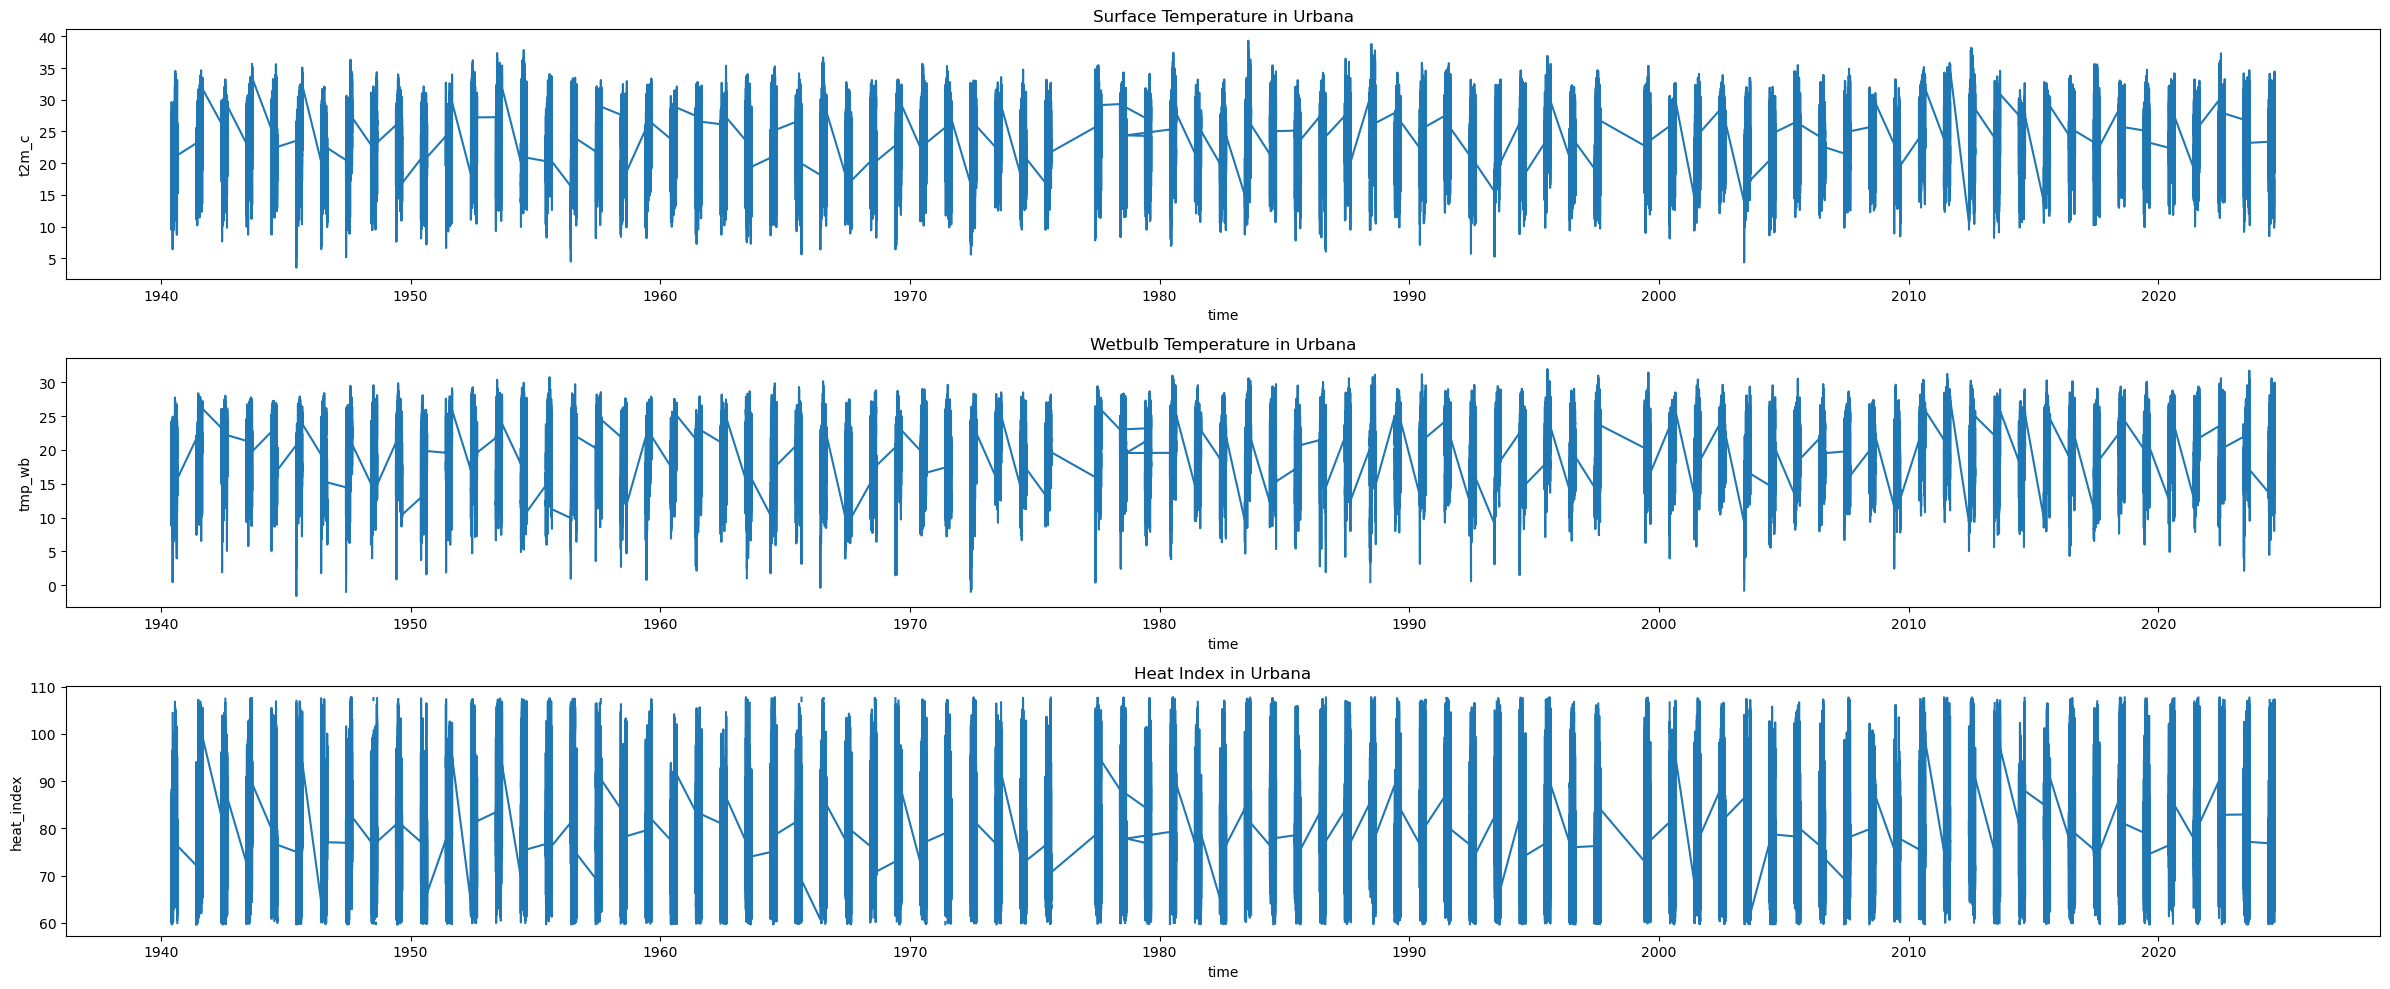

In [9]:
plt.figure(figsize=[24,10])

plt.subplot(3,1,1); urbana_ds.t2m_c.plot(); plt.title("Surface Temperature in Urbana");
plt.subplot(3,1,2); urbana_ds.tmp_wb.plot(); plt.title("Wetbulb Temperature in Urbana");
# plt.subplot(3,1,3); urbana_ds.heat_index.plot(); plt.title("Heat Index in Urbana");

# Clean the outliers
data = urbana_ds.heat_index
lower_bound, upper_bound = data.quantile([0.01, 0.99]) 
cleaned_data = data.where((data >= lower_bound) & (data <= upper_bound), np.nan)

plt.subplot(3,1,3); cleaned_data.plot(); plt.title("Heat Index in Urbana");

plt.tight_layout();

Available Year: 1940-2024


Enter year here:  2023


Dangerous Wet Bulb Temperature. Total Hour 6
Intersection: 2023-06-09T03
Intersection: 2023-06-09T04
Intersection: 2023-08-23T17
Intersection: 2023-08-23T23
Intersection: 2023-08-24T16
Intersection: 2023-08-24T23
Dangerous Heat Index Temperature. Total Hour 6
Intersection: 2023-08-23T19
Intersection: 2023-08-23T20
Intersection: 2023-08-23T21
Intersection: 2023-08-23T22
Intersection: 2023-08-24T17
Intersection: 2023-08-24T23


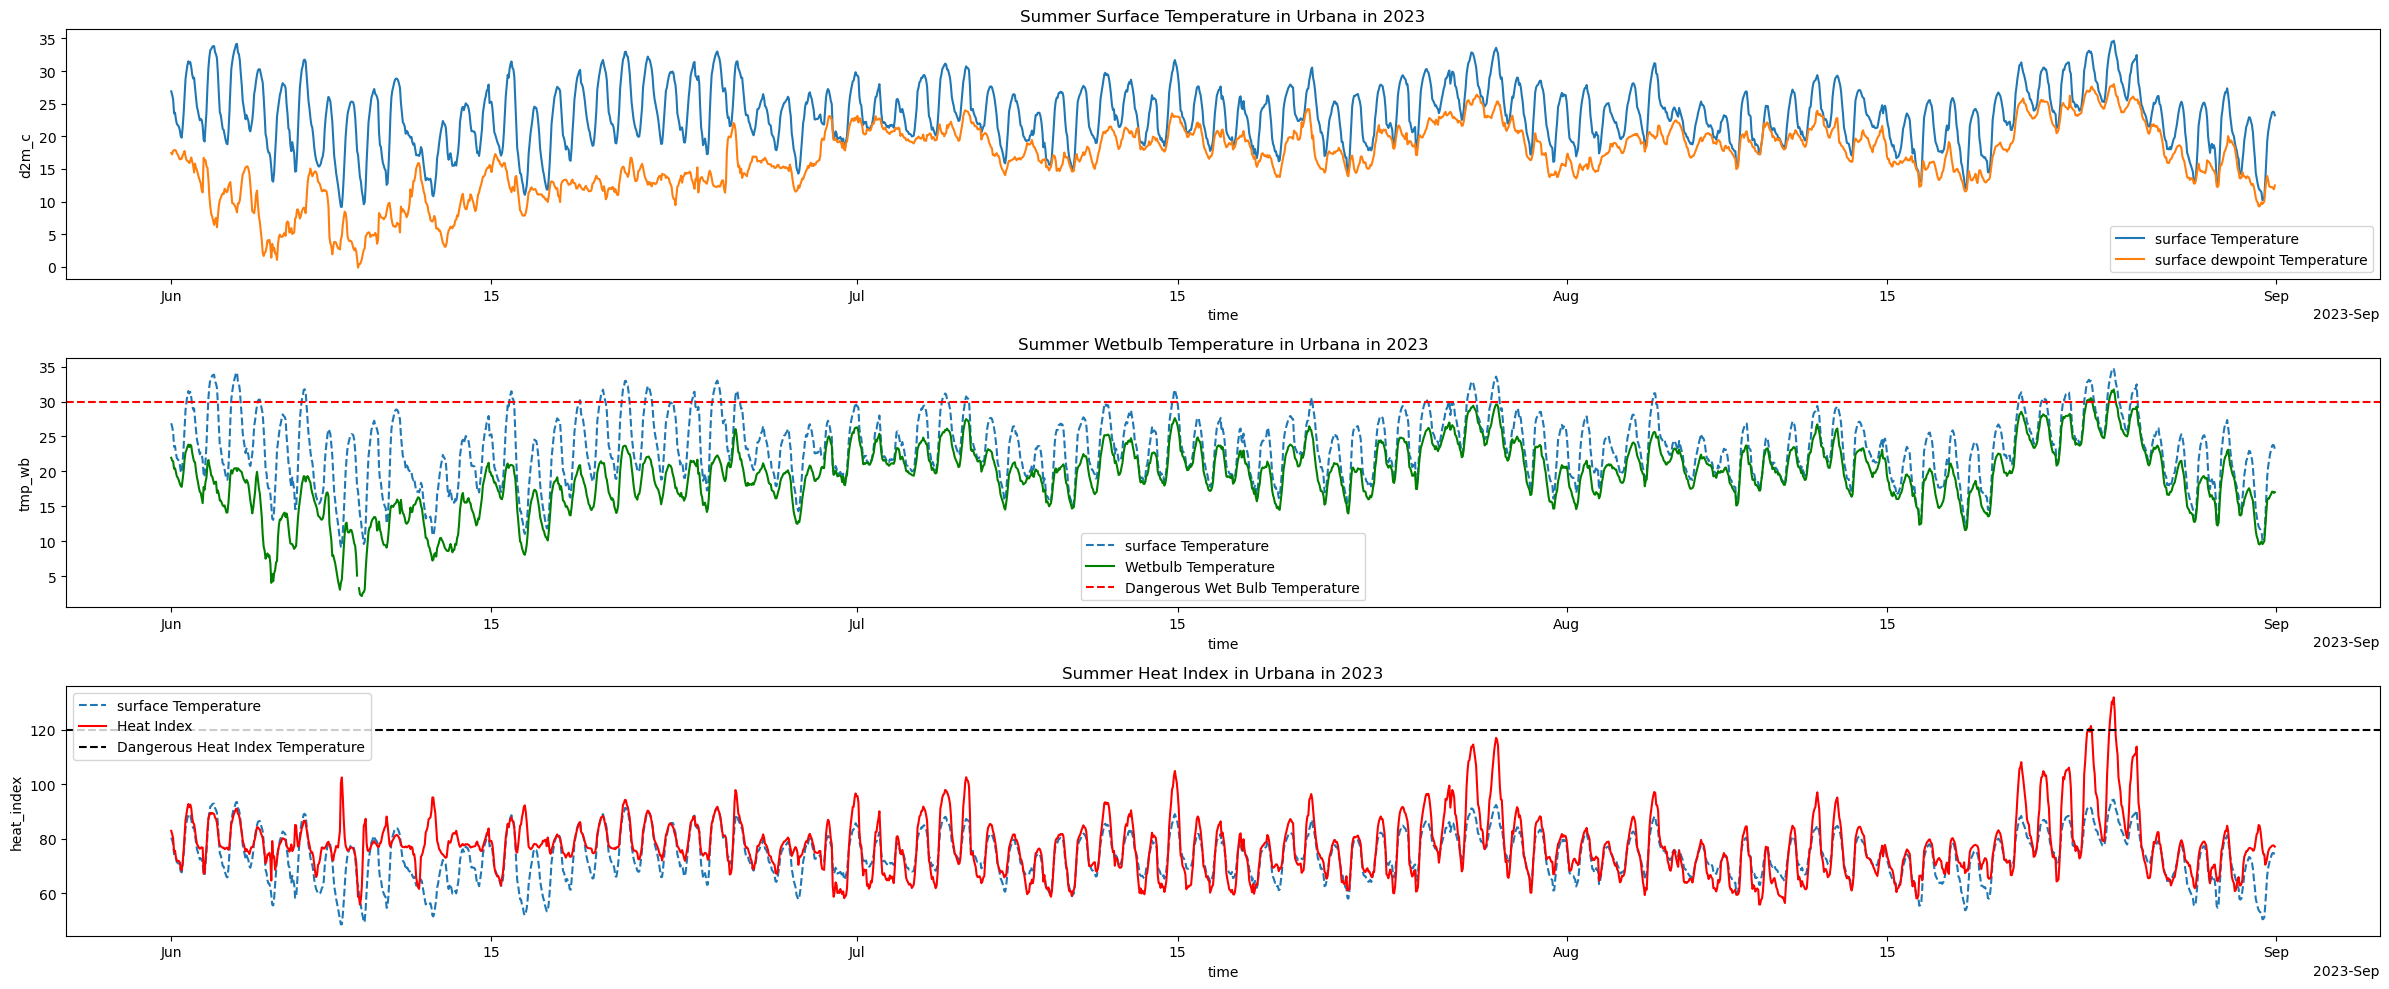

In [6]:
plt.figure(figsize=[24,10])

# Set up 
print("Available Year: 1940-2024")
year = input("Enter year here: ")

# Graph for 
plt.subplot(3,1,1); 

urbana_ds.sel(valid_time=year).t2m_c.plot(label='surface Temperature'); 
urbana_ds.sel(valid_time=year).d2m_c.plot(label='surface dewpoint Temperature'); 

plt.legend(); plt.title(f"Summer Surface Temperature in Urbana in {year}");

plt.subplot(3,1,2); 

urbana_ds.sel(valid_time=year).t2m_c.plot(label='surface Temperature', linestyle='--');
urbana_ds.sel(valid_time=year).tmp_wb.plot(label='Wetbulb Temperature', color='g'); 
plt.axhline(y=30, color='red', linestyle='--', label='Dangerous Wet Bulb Temperature')

plt.legend(); plt.title(f"Summer Wetbulb Temperature in Urbana in {year}");

plt.subplot(3,1,3); 

(urbana_ds.sel(valid_time=year).t2m_c * 9/5 + 32).plot(label='surface Temperature', linestyle='--');
urbana_ds.sel(valid_time=year).heat_index.plot(label='Heat Index', color='r');
plt.axhline(y=120, color='black', linestyle='--', label='Dangerous Heat Index Temperature')

plt.legend(); plt.title(f"Summer Heat Index in Urbana in {year}");

plt.tight_layout();

# # # # # # # # # # # # # # # # # # # # # # # # # # # # 
#
# Find intersection of Dangerous Wet bulb temperature
#
# # # # # # # # # # # # # # # # # # # # # # # # # # # # 

tmp_data = urbana_ds.sel(valid_time=year).tmp_wb

wb_diff = tmp_data - 30

intersect = np.where(np.diff(np.sign(wb_diff)) != 0)[0]

print(f"Dangerous Wet Bulb Temperature. Total Hour {intersect.size}")

for time in tmp_data.isel(valid_time=intersect).valid_time.values:
    print("Intersection:", str(np.datetime64(time, 'h')) )

print("===========================")

# Find intersection of Dangerous NOAA's Heat Index temperature

tmp_data = urbana_ds.sel(valid_time=year).heat_index

wb_diff = tmp_data - 120

intersect = np.where(np.diff(np.sign(wb_diff)) != 0)[0]

print(f"Dangerous Heat Index Temperature. Total Hour {intersect.size}")

for time in tmp_data.isel(valid_time=intersect).valid_time.values:
    print("Intersection:", str(np.datetime64(time, 'h')) )

print("===========================")

### Finding Daily highs below

In [7]:
# Make Daily highs
max_tmp = urbana_ds.t2m_c.groupby(urbana_ds.valid_time.dt.date).max()
max_wb = urbana_ds.tmp_wb.groupby(urbana_ds.valid_time.dt.date).max()
max_hi = urbana_ds.heat_index.groupby(urbana_ds.valid_time.dt.date).max()

Available Year: 1940-2024


Enter year here:  2023


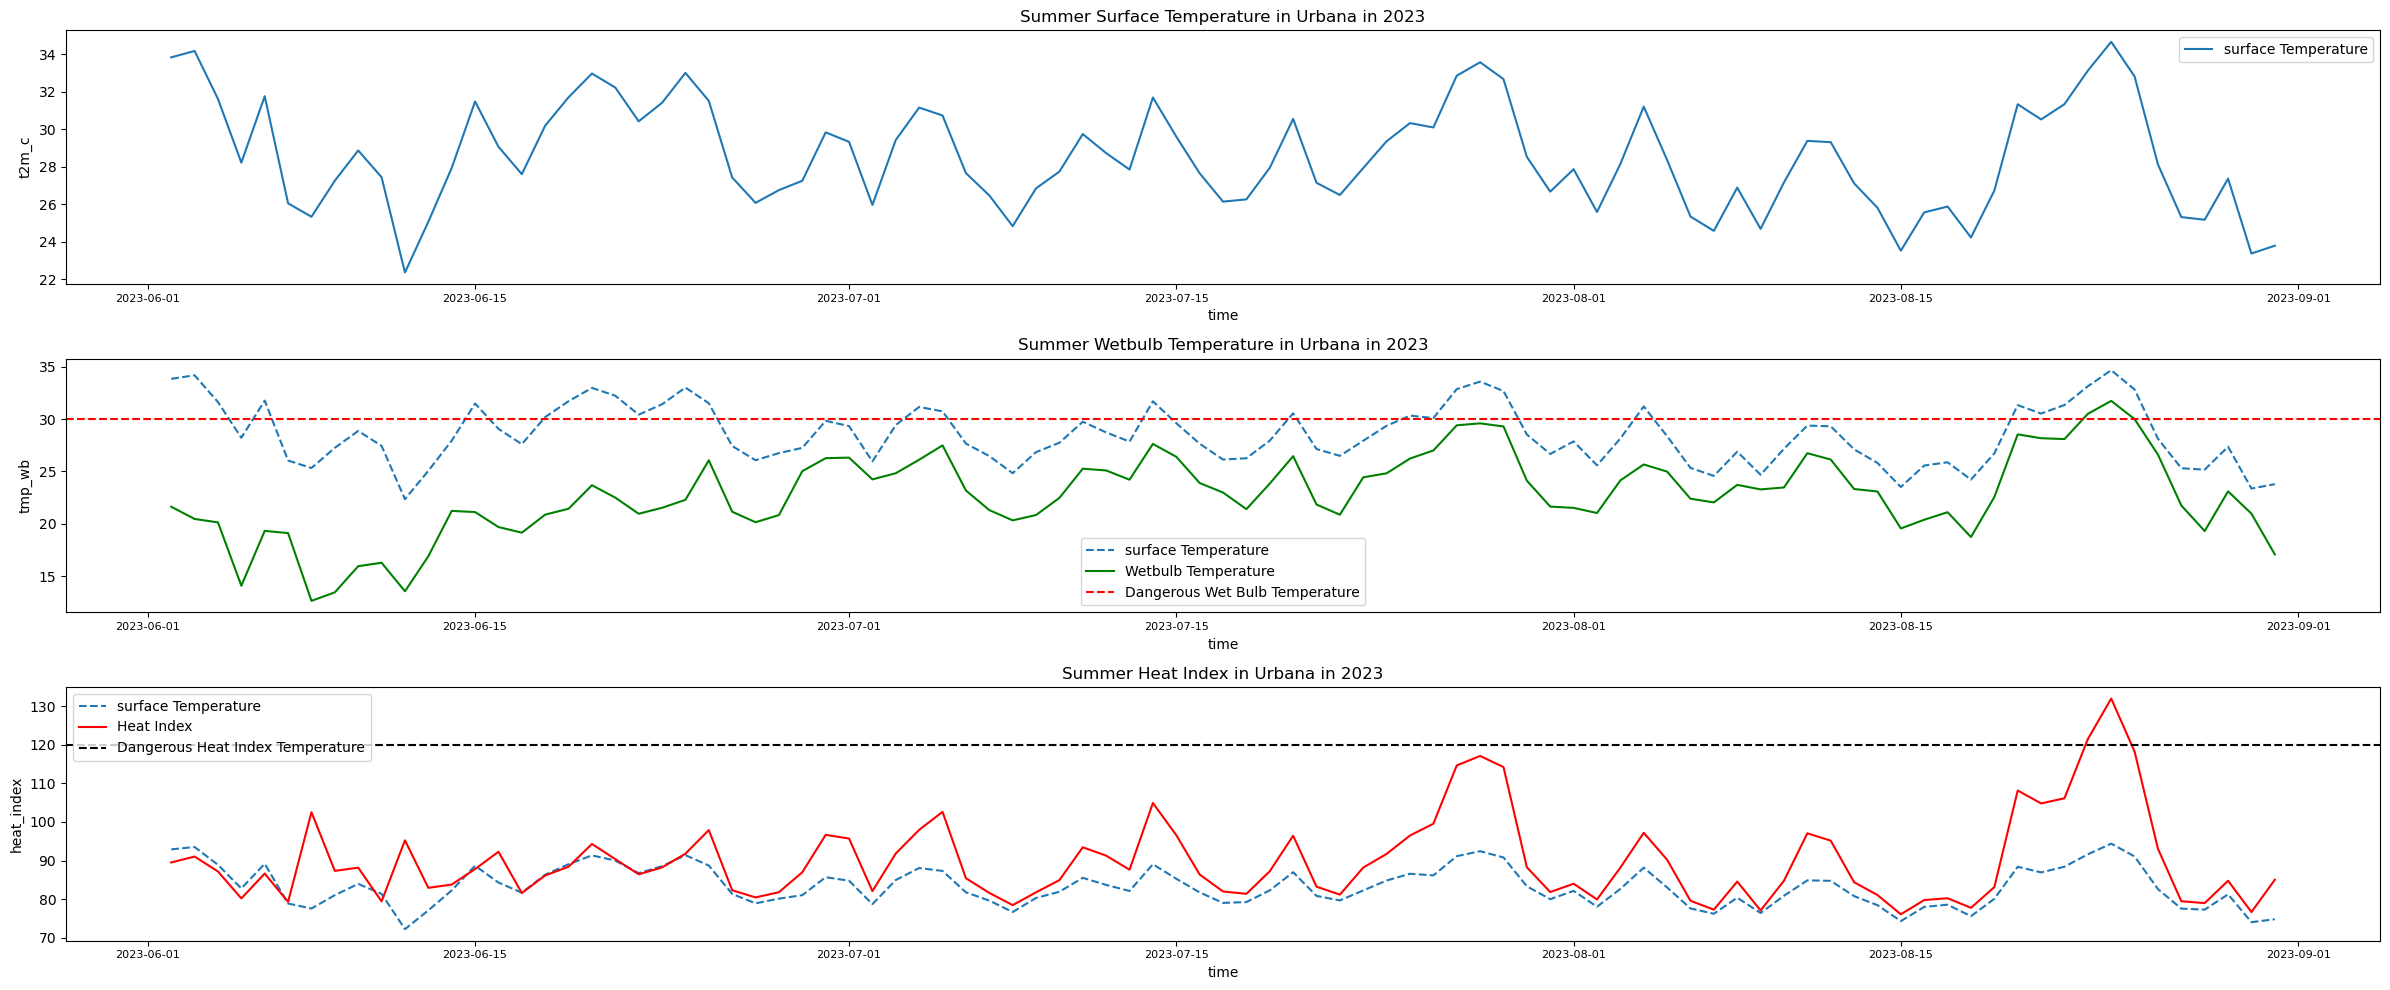

In [8]:
print("Available Year: 1940-2024")
year_ind = int(input("Enter year here: "))

plt.figure(figsize=[24,10])

# Remove 1976 and 1998 year out, data not available for some reason
if year_ind == 1976 or year_ind == 1998:
    print("Data in this year does not exist")

if year_ind > 1976:
    year_ind = year_ind - 1
if year_ind > 1998:
    year_ind = year_ind - 1

year_ind =  year_ind - 1939

if year_ind == -1:
    clock = range(0,92)
else:
    clock = range((92*(year_ind-1))+1,92*year_ind)

# Graph for 
plt.subplot(3,1,1); 

max_tmp.isel(date=clock).plot(label='surface Temperature'); 

plt.xticks(fontsize = 8); plt.legend(); plt.title(f"Summer Surface Temperature in Urbana in {year}");

plt.subplot(3,1,2); 

max_tmp.isel(date=clock).plot(label='surface Temperature', linestyle='--');
max_wb.isel(date=clock).plot(label='Wetbulb Temperature', color='g'); 
plt.axhline(y=30, color='red', linestyle='--', label='Dangerous Wet Bulb Temperature')

plt.xticks(fontsize = 8); plt.legend(); plt.title(f"Summer Wetbulb Temperature in Urbana in {year}");

plt.subplot(3,1,3); 

(max_tmp.isel(date=clock) * 9/5 + 32).plot(label='surface Temperature', linestyle='--');
max_hi.isel(date=clock).plot(label='Heat Index', color='r');
plt.axhline(y=120, color='black', linestyle='--', label='Dangerous Heat Index Temperature')

plt.xticks(fontsize = 8); plt.legend(); plt.title(f"Summer Heat Index in Urbana in {year}");

plt.tight_layout();

### Quantile Test

In [6]:
from sklearn.linear_model import QuantileRegressor
import sklearn

In [25]:
urbana_ds

<xarray.Dataset> Size: 9MB
Dimensions:     (valid_time: 185472)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 1MB 1940-06-01 ... 2024-08-31T23:...
    latitude    float64 8B 40.25
    longitude   float64 8B -88.25
    expver      (valid_time) <U4 3MB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    d2m         (valid_time) float32 742kB 286.0 284.9 284.3 ... 288.2 288.7
    t2m         (valid_time) float32 742kB 291.0 289.6 288.1 ... 300.1 299.6
    t2m_c       (valid_time) float32 742kB 17.82 16.44 14.93 ... 26.91 26.45
    d2m_c       (valid_time) float32 742kB 12.8 11.72 11.15 ... 15.64 15.05 15.6
    tmp_wb      (valid_time) float32 742kB 14.47 13.11 12.07 ... 20.59 20.65
    heat_index  (valid_time) float32 742kB 74.31 76.43 77.78 ... 81.86 81.25
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-04T06:37 GRIB to CDM+CF via cfgrib-0.9.1...

In [15]:
temperature = urbana_ds['t2m_c'].values.flatten()
wetbulb = urbana_ds['tmp_wb'].values.flatten()
heat_index = urbana_ds['heat_index'].values.flatten()

X = np.ones((temperature.shape[0], 1))

def get_quantile (y,quantile=0.95):
    qr = QuantileRegressor(quantile=quantile,alpha=0)
    qr.fit(X, y)
    return qr.intercept_

tmp_95 = get_quantile(temperature, 0.95)
# wetbulb_95 = get_quantile(wetbulb, 0.95)
# heat_index_95 = get_quantile(heat_index, 0.95)

In [16]:
tmp_95

30.633941650390625

In [9]:
urbana_ds['t2m_c'].values.flatten()

array([17.815094, 16.438385, 14.92691 , ..., 28.448883, 26.91397 ,
       26.446198], dtype=float32)

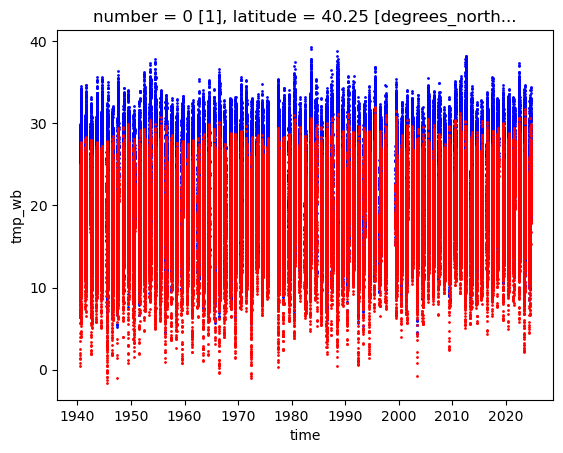

In [6]:
urbana_ds.plot.scatter(x="valid_time",y="t2m_c", color='b', s=1)
urbana_ds.plot.scatter(x="valid_time",y="tmp_wb", color='r', s=1)
#urbana_ds.plot.scatter(x="valid_time",y="heat_index", color='g', s=1)

In [29]:
urbana_ds.valid_time

<xarray.DataArray 'valid_time' (valid_time: 185472)> Size: 1MB
array(['1940-06-01T00:00:00.000000000', '1940-06-01T01:00:00.000000000',
       '1940-06-01T02:00:00.000000000', ..., '2024-08-31T21:00:00.000000000',
       '2024-08-31T22:00:00.000000000', '2024-08-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 1MB 1940-06-01 ... 2024-08-31T23:...
    latitude    float64 8B 40.25
    longitude   float64 8B -88.25
    expver      (valid_time) <U4 3MB '0001' '0001' '0001' ... '0001' '0001'
Attributes:
    long_name:      time
    standard_name:  time

In [18]:
plt.scatter(urbana_ds['t2m_c'].values, urbana_ds.valid_time.values, s=0.02)

In [9]:
# Data
df = urbana_ds

# ------------------------------------------------------------------------------
# Fit Quantile Regression for each temperature metric
# ------------------------------------------------------------------------------
# metrics = ['t2m_c', 'tmp_wb', 'heat_index']
metrics = ['t2m_c']
results = {}

for metric in metrics:
    sub_df = df
    
    X = sub_df[metric].values
    X = X[:, np.newaxis]

    y = sub_df.valid_time.values
    

    qreg = QuantileRegressor(quantile=0.95, alpha=0.0)
    
    qreg.fit(X, y)
    
    slope = qreg.coef_[0]
    intercept = qreg.intercept_
    
    results[metric] = {
        'slope_95th': slope,
        'intercept_95th': intercept
    }


for metric, result in results.items():
    print(f"95th percentile regression for {metric}:")
    print(f"  slope: {result['slope_95th']:.4f}")
    print(f"  intercept: {result['intercept_95th']:.4f}")
    print("")


95th percentile regression for t2m_c:
  slope: 5455436308334050.0000
  intercept: 1472967949577431296.0000



In [32]:
X

array([[17.815094],
       [16.438385],
       [14.92691 ],
       ...,
       [28.448883],
       [26.91397 ],
       [26.446198]], dtype=float32)

In [12]:
rearr_X = X.T
rearr_X

array([[17.815094, 16.438385, 14.92691 , ..., 28.448883, 26.91397 ,
        26.446198]], dtype=float32)

In [40]:
y_pred = qreg.predict(X)

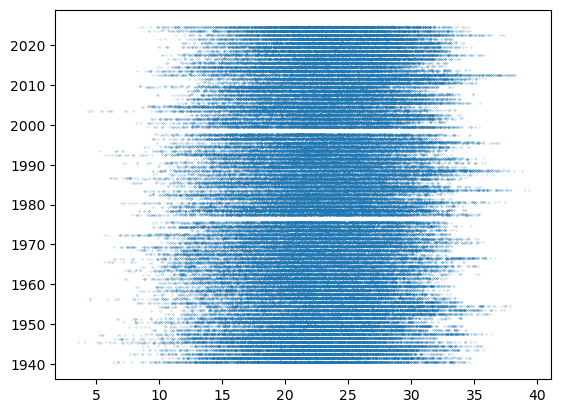

In [7]:
plt.scatter(urbana_ds['t2m_c'].values, urbana_ds.valid_time.values, s=0.02)

In [15]:


# plt.plot(X, y_pred)

# Define the slope and intercept
m = result['slope_95th']
c = result['intercept_95th']

x = np.linspace(0, 40, 10)

y = m * x + c

plt.scatter(urbana_ds['t2m_c'].values, urbana_ds.valid_time.values, s=0.02)

#plt.plot(x, y)

In [ ]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

In [ ]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

## Ignore below

Available Year: 1940-2024


Enter year here:  2020


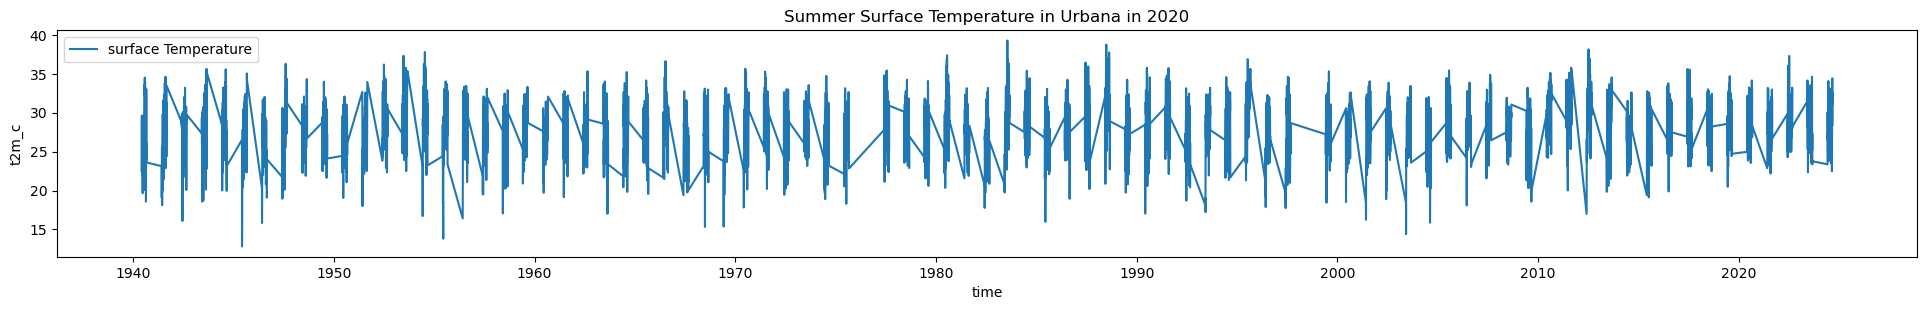

In [30]:
max_tmp = urbana_ds.t2m_c.groupby(urbana_ds.valid_time.dt.date).max()

plt.figure(figsize=[24,10])

# Set up 
print("Available Year: 1940-2024")
year = input("Enter year here: ")

# Graph for 
plt.subplot(3,1,1); 

max_tmp.sel(valid_time=year).t2m_c.plot(label='surface Temperature'); 

plt.legend(); plt.title(f"Summer Surface Temperature in Urbana in {year}");

In [11]:
# Old workflow
max_tmp, max_dpt, max_wb, max_hi = [],[],[],[]
for day in range(1, 93, 1):
    if day == 1:
        clock = range(0,24)
    else:
        clock = range((24*(day-1))+1,24*day)
    
    # max_tmp.append(urbana_ds.isel(valid_time=clock).t2m_c.max())
    # max_dpt = urbana_ds.isel(valid_time=clock).d2m_c.max()
    # max_wb = urbana_ds.isel(valid_time=clock).tmp_wb.max()
    # max_hi = urbana_ds.isel(valid_time=clock).heat_index.max()
    max_tmp.append(urbana_ds.isel(valid_time=clock).t2m_c.max().values)
max_tmp

[array(22.53701782),
 array(25.32510376),
 array(26.41104126),
 array(26.81069946),
 array(28.14151001),
 array(29.65200806),
 array(28.16885376),
 array(26.6991272),
 array(27.89712524),
 array(26.43545532),
 array(22.40322876),
 array(26.26577759),
 array(23.01187134),
 array(24.33511353),
 array(27.2484436),
 array(27.29116821),
 array(27.13223267),
 array(27.66104126),
 array(24.32705688),
 array(19.59024048),
 array(19.66275024),
 array(27.18887329),
 array(28.74038696),
 array(23.45596313),
 array(21.97915649),
 array(24.86636353),
 array(26.4960022),
 array(27.47549438),
 array(21.32803345),
 array(25.12637329),
 array(23.46450806),
 array(19.87319946),
 array(20.89517212),
 array(22.02798462),
 array(24.32192993),
 array(25.59951782),
 array(26.55484009),
 array(27.53604126),
 array(27.5218811),
 array(28.67349243),
 array(29.13345337),
 array(21.43984985),
 array(20.06387329),
 array(23.81607056),
 array(26.88027954),
 array(22.95791626),
 array(23.46035767),
 array(26.4779357

In [15]:
daily_max = urbana_ds.groupby(urbana_ds.coords['valid_time'].dt.floor("D")).max()

plt.figure(figsize=[24,10])

# Set up 
print("Available Year: 1940-2024")
year = input("Enter year here: ")

# Graph for 
plt.subplot(3,1,1); 

daily_max.t2m_c.plot(label='surface Temperature'); 
daily_max.d2m_c.plot(label='surface dewpoint Temperature'); 

plt.legend(); plt.title(f"Summer Surface Temperature in Urbana in {year}");

ValueError: index must be monotonic for resampling

In [6]:
ds_tmp

<xarray.Dataset> Size: 876kB
Dimensions:     (valid_time: 15640, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 125kB 1940-06-01T09:00:00 ... 202...
  * latitude    (latitude) float64 16B 40.25 40.0
  * longitude   (longitude) float64 16B -88.25 -88.0
    expver      (valid_time) <U4 250kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 250kB ...
    t2m         (valid_time, latitude, longitude) float32 250kB 283.3 ... 302.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-03T00:12 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
ds_tmp = ds_tmp.assign(t2m_c = ds_tmp.t2m - 273.15)

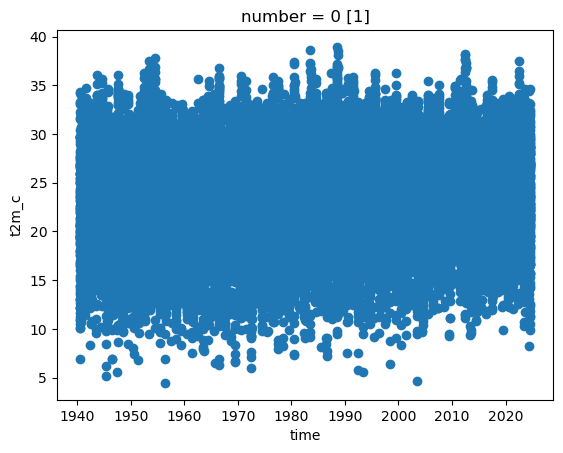

In [20]:
ds_tmp.t2m_c.mean(dim=["latitude", "longitude"]).plot(marker="o",linestyle='')

In [21]:
ds_flux

<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 15640, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 125kB 1940-06-01T09:00:00 ... 202...
  * latitude    (latitude) float64 16B 40.25 40.0
  * longitude   (longitude) float64 16B -88.25 -88.0
    expver      (valid_time) <U4 250kB ...
Data variables:
    ssr         (valid_time, latitude, longitude) float32 250kB ...
    str         (valid_time, latitude, longitude) float32 250kB ...
    tsr         (valid_time, latitude, longitude) float32 250kB ...
    ttr         (valid_time, latitude, longitude) float32 250kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-03T00:12 GRIB to CDM+CF via cfgrib-0.9.1...

In [22]:
ds_flux = ds_flux.assign(toa = ds_flux.tsr - ds_flux.ttr)
ds_flux = ds_flux.assign(tas = ds_flux.ssr - ds_flux.str)